# Régression

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/use-cases/regression.ipynb)

Nous démontrons ici l'usage des algorithmes de régression pour la prédiction d'un prix de vente immobilier. Les données sont issues d'une [compétition Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). 

In [59]:
from IPython import get_ipython

# Supprimer les commentaires pour installer
# !pip3 install -q -U matplotlib
# !pip3 install -q -U numpy
# !pip3 install -q -U pandas
# !pip3 install -q -U scikit-learn
# !pip3 install -q -U xgboost

# À installer dans tous les cas pour Google Colab
if 'google.colab' in str(get_ipython()):
    !pip3 install -q -U scikit-optimize

## Chargement des Données d'Entraînement

In [60]:
import os

csv_directory = './regression'
work_directory = './regression'

# Récupération des données pour Kaggle
if 'KAGGLE_URL_BASE' in os.environ:
  work_directory = '/kaggle/working' 
  csv_directory = '/kaggle/input/house-prices-advanced-regression-techniques'

# Récupération des données pour Google Colab
if 'google.colab' in str(get_ipython()):
  !curl --create-dirs -O --output-dir $csv_directory "https://raw.githubusercontent.com/digillia/Digillia-Colab/main/use-cases/regression/test.csv"
  !curl --create-dirs -O --output-dir $csv_directory "https://raw.githubusercontent.com/digillia/Digillia-Colab/main/use-cases/regression/train.csv"

In [61]:
import pandas as pd
df = pd.read_csv(f'{csv_directory}/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Distribution des Données d'Entraînement

In [62]:
# Types de données du dataframe 
list(set(df.dtypes.tolist()))

[dtype('float64'), dtype('int64'), dtype('O')]

### Données numériques

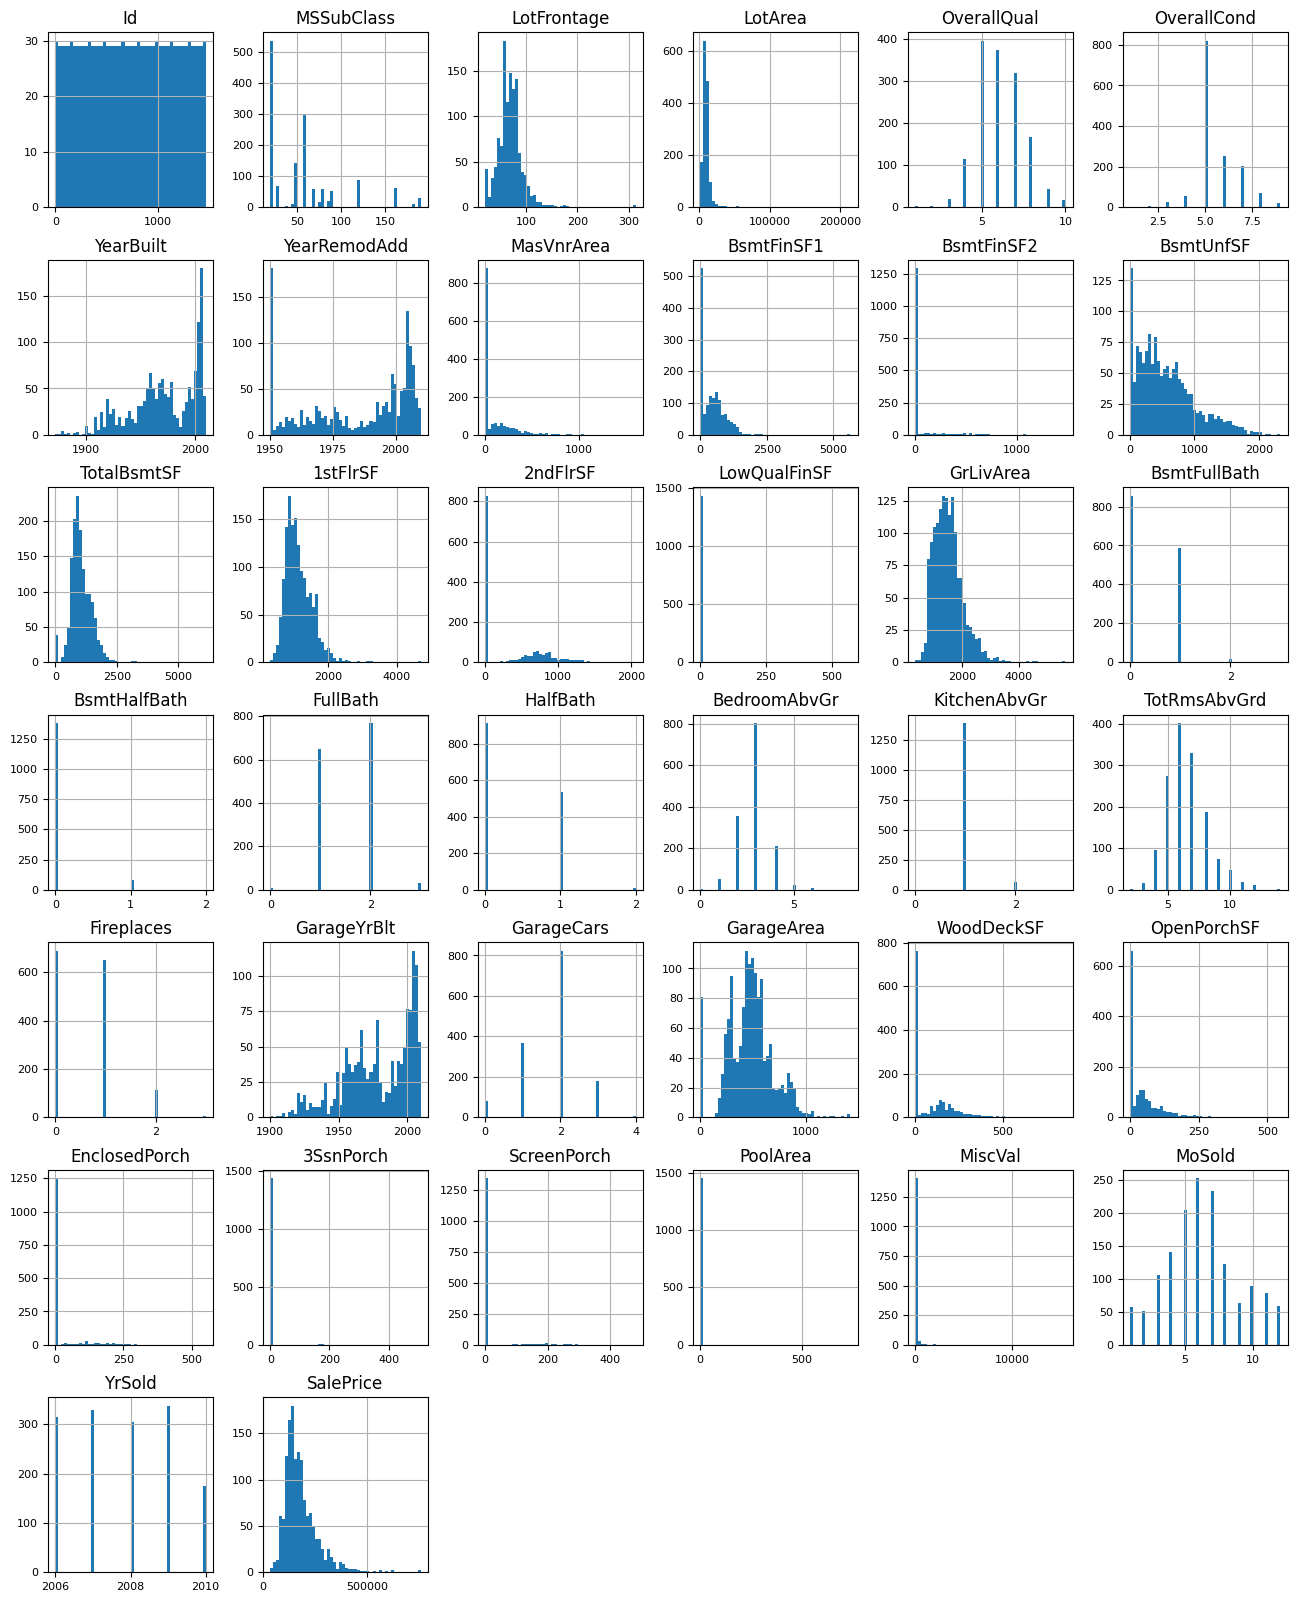

In [63]:
def plot_num_distribution(df: pd.DataFrame):
    df_num = df.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

plot_num_distribution(df)

## Traitement des Données

### Suppression des colonnes avec trop de données manquantes

In [64]:
def keep_full_columns(df: pd.DataFrame, threshold: int = 5):
    missing_counts = df.isna().sum() 
    cols_to_keep = missing_counts[missing_counts < threshold].index
    return df[cols_to_keep]

df = keep_full_columns(df, 1)

In [65]:
missing_counts = df.isna().sum()
missing_counts.sort_values(ascending=False)

Id              0
Fireplaces      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
               ..
Foundation      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
SalePrice       0
Length: 62, dtype: int64

### Corrélation des Surfaces (SF)

Calcul de GrLivArea - 2ndFlrSF - 1stFlrSF - LowQualFinSF

In [66]:
df_copy = df.copy()
df_copy['Diff1'] = df_copy['GrLivArea'] - df_copy['2ndFlrSF'] - df_copy['1stFlrSF'] - df_copy['LowQualFinSF']
df_copy['Diff1'].value_counts()

Diff1
0    1460
Name: count, dtype: int64

Calcul de TotalBsmtSF - BsmtFinSF1 - BsmtFinSF2 - BsmtFinSF2

In [67]:
df_copy['Diff2'] = df_copy['TotalBsmtSF'] - df_copy['BsmtFinSF1'] - df_copy['BsmtFinSF2'] - df_copy['BsmtUnfSF']
df_copy['Diff2'].value_counts()

Diff2
0    1460
Name: count, dtype: int64

### Préparation d'un jeu d'Entraînement et de Test

In [68]:
from sklearn.model_selection import train_test_split

random_state = 42
target = 'SalePrice'
y = df[target]
# Suppression des données corrélées
# X = df.drop(columns=['Id', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', target])
X = df.drop(columns=['Id', 'GrLivArea', 'TotalBsmtSF', target])
X_encoded = pd.get_dummies(X, dtype=float)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=.2, random_state=random_state)

### Usage d'une Forêt Aléatoire pour Déterminer l'Importance des Caractéristiques

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Entrainement d'un modèle de régression de forêt aléatoire
model = RandomForestRegressor()
model.fit(X_train, y_train)

print(f"Score R2 d'entraînement: {model.score(X_train, y_train)}")
print(f"Score R2 de test: {model.score(X_test, y_test)}")

Score R2 d'entraînement: 0.9773485917291067
Score R2 de test: 0.8900306516970617


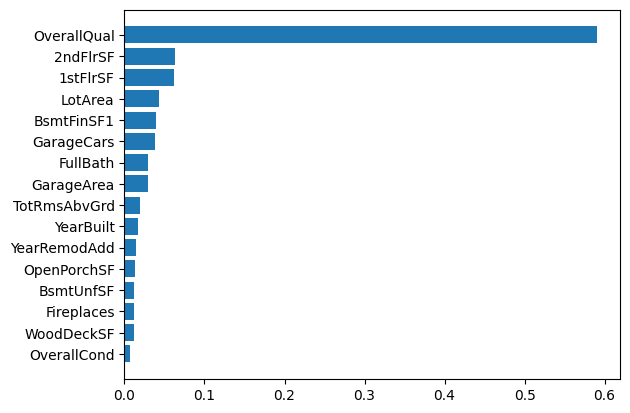

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Sélection des 12 caractéristiques les plus impactantes
importances = model.feature_importances_
indices = np.argsort(importances)[-16:]

# Affichage
fig, ax = plt.subplots()
ax.barh(range(len(indices)), importances[indices])
ax.set_yticks(range(len(indices)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

### Réduction de la Dimension des Jeux d'Entraînement et de Test

In [76]:
X_train = X_train.iloc[:,indices]
X_test = X_test.iloc[:,indices]

In [77]:
from sklearn.ensemble import RandomForestRegressor

# Entrainement d'un modèle de régression de forêt aléatoire
model = RandomForestRegressor()
model.fit(X_train, y_train)

print(f"Score R2 d'entraînement: {model.score(X_train, y_train)}")
print(f"Score R2 de test: {model.score(X_test, y_test)}")

Score R2 d'entraînement: 0.9758228847186348
Score R2 de test: 0.8876058426422843


### Analyse des corrélations

Les données sont assez peu corrélées après réduction de dimension.

<Axes: >

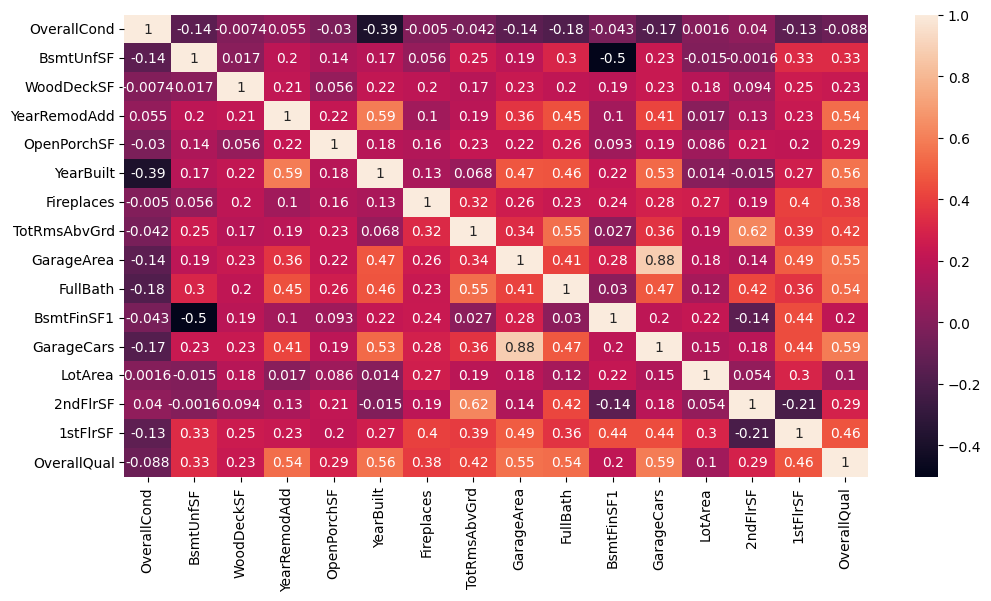

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(12,6)) 
sb.heatmap(X_train.corr(), annot=True)

In [ ]:
import warnings
import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
    
class DummyEstimator(BaseEstimator):
  def fit(self): pass
  def score(self): pass
        
# Création d'un pipeline avec un estimateur par défaut
pipe = Pipeline([
    ('scaler', MinMaxScaler()), # Comment to avoid ConvergenceWarning
    ('clf', DummyEstimator())
])

# Paramètre de la grille de recherche
param_grid = [
  {
    'clf': [DecisionTreeRegressor(random_state=random_state)],
    'clf__max_depth': [2, 3, 4],
    'clf__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
  },
  {
     'clf': [GradientBoostingRegressor(random_state=random_state)],
     'clf__loss': ['squared_error', 'huber', 'absolute_error'],
     'clf__n_estimators': [10, 50, 100],
     'clf__learning_rate': [0.05, 0.1, 0.5],
  },
  {
    'clf': [ElasticNet(random_state=random_state)],
    'clf__alpha': [0.1, 1, 10, 100],
    'clf__l1_ratio': [0.1, 0.5, 0.9]
  },
  {
    'clf': [SGDRegressor(random_state=random_state)],
    'clf__loss': ['squared_error', 'huber'],
    'clf__penalty': ['l2', 'l1', 'elasticnet']
  },
  {
    'clf': [BayesianRidge()],
    'clf__alpha_1': [0.1, 1, 10, 100],
    'clf__alpha_2': [0.1, 1, 10, 100],
  },
  {
    'clf': [KernelRidge()],
    'clf__alpha': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'polynomial', 'rbf', 'sigmoid'] # gamma
  },
  {
    'clf': [MLPRegressor(random_state=random_state)],
    'clf__hidden_layer_sizes': [(10,), (50,), (100,)],
    'clf__activation': ['identity', 'logistic', 'tanh', 'relu'],
  },
  {
    'clf': [RandomForestRegressor(random_state=random_state)],
    'clf__n_estimators': [10, 50, 100],
    'clf__criterion': ['squared_error', 'poisson'],
  },
  {
    'clf': [XGBRegressor(random_state=random_state)],
    'clf__learning_rate': [0.05, 0.1, 0.5],
    'clf__max_depth': [2, 3, 4],
  },
  {
    'clf': [SVR(kernel='linear')],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__epsilon': [0.1, 0.5, 1, 2],
  },
  {
    'clf': [SVR(kernel='rbf')],
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__gamma': [0.1, 0.5, 1, 2],
  }
]

# Création de grille de recherche
gs = GridSearchCV(
  estimator=pipe,
  param_grid=param_grid,
  scoring='r2',
  cv=5,
  n_jobs=-1, # Répartition sur tous les processeurs
  refit=True,
  return_train_score=True,
  verbose=2
)

# Entraînement de la grille de recherche
# MinMaxScaler raises some ConvergenceWarning which we ignore
# because they yield a slightly better score in the end
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
  gs.fit(X_train, y_train)  # ATTENTION! compter des heures avec la base MNIST

Fitting 5 folds for each of 156 candidates, totalling 780 fits
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=3; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=3; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth=2; total time=   0.0s
[CV] END clf=DecisionTreeRegressor(random_state=42), clf__criterion=squared_error, clf__max_depth

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
 

[CV] END clf=SGDRegressor(random_state=42), clf__loss=huber, clf__penalty=elasticnet; total time=   0.1s
[CV] END clf=SGDRegressor(random_state=42), clf__loss=huber, clf__penalty=l2; total time=   0.1s
[CV] END clf=SGDRegressor(random_state=42), clf__loss=huber, clf__penalty=l2; total time=   0.1s
[CV] END clf=SGDRegressor(random_state=42), clf__loss=huber, clf__penalty=l1; total time=   0.1s
[CV] END clf=BayesianRidge(), clf__alpha_1=0.1, clf__alpha_2=0.1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=0.1, clf__alpha_2=0.1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=0.1, clf__alpha_2=1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=0.1, clf__alpha_2=1; total time=   0.0s
[CV] END clf=SGDRegressor(random_state=42), clf__loss=huber, clf__penalty=l2; total time=   0.0s
[CV] END clf=SGDRegressor(random_state=42), clf__loss=huber, clf__penalty=elasticnet; total time=   0.1s
[CV] END clf=BayesianRidge(), clf__alpha_1=0.1, clf__alpha_2=0.1; 

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf=BayesianRidge(), clf__alpha_1=1, clf__alpha_2=100; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=1, clf__alpha_2=100; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=1, clf__alpha_2=100; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=0.1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=1, clf__alpha_2=100; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=1, clf__alpha_2=100; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=0.1; total time=   0.1s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=0.1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=0.1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=1; total time=   0.0s
[CV] END clf=BayesianRidge(), clf__alpha_1=10, clf__alpha_2=1; total time=   0.0s
[CV

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=linear; total time=   0.1s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=linear; total time=   0.1s
[CV] END clf=GradientBoostingRegressor(random_state=42), clf__learning_rate=0.5, clf__loss=huber, clf__n_estimators=100; total time=   0.8s
[CV] END .clf=KernelRidge(), clf__alpha=0.1, clf__kernel=rbf; total time=   0.1s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=sigmoid; total time=   0.1s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=polynomial; total time=   0.0s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=linear; total time=   0.0s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=polynomial; total time=   0.0s
[CV] END .clf=KernelRidge(), clf__alpha=0.1, clf__kernel=rbf; total time=   0.0s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=sigmoid; total time=   0.0s
[CV] END clf=KernelRidge(), clf__alpha=0.1, clf__kernel=sigmoid; total time=   0.0s
[CV] END clf=KernelRidg

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(10,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(10,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(50,); total time=   0.3s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(10,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(10,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(100,); total time=   0.5s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(10,); total time=   0.2s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(10,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(10,); total time=   0.1s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(10,); total time=   0.2s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=identity, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(50,); total time=   0.3s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(10,); total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=logistic, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=squared_error, clf__n_estimators=10; total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=squared_error, clf__n_estimators=10; total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(50,); total time=   0.3s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(100,); total time=   0.4s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=tanh, clf__hidden_layer_sizes=(100,); total time=   0.5s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(50,); total time=   0.3s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=squared_error, clf__n_estimators=10; total time=   0.1s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=squared_error, clf__n_estimators=10; total time=   0.1s
[CV] END clf=RandomForestRegressor(random_state=42),

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=squared_error, clf__n_estimators=10; total time=   0.1s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=squared_error, clf__n_estimators=50; total time=   0.3s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=poisson, clf__n_estimators=10; total time=   0.1s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(50,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(10,); total time=   0.2s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=relu, clf__hidden_layer_sizes=(100,); total time=   0.3s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=poisson, clf__n_estimators=10; total time=   0.1s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=poisson, clf__n_estimators=10; total time=   0.1s
[CV] END clf=RandomForestRegressor(random_state=4

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), clf__learning_rate=0.05, clf__max_depth=3; total time=   0.0s
[CV] END clf=RandomForestRegressor(random_state=42), clf__criterion=poisson, clf__n_estimators=50; total time=   0.3s
[CV] END clf=MLPRegressor(random_state=42), clf__activation=r

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), clf__learning_rate=0.05, clf__max_depth=4; total time=   0.1s
[CV] END clf=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=Non

In [ ]:
# Résultats de la grille de recherche
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')[['rank_test_score', 'param_clf', 'params', 'mean_train_score', 'mean_test_score']].head()

,rank_test_score,param_clf,params,mean_train_score,mean_test_score
112,1,"XGBRegressor(base_score=None, booster=None, ca...","{'clf': XGBRegressor(base_score=None, booster=...",0.976151,0.849457
111,2,"XGBRegressor(base_score=None, booster=None, ca...","{'clf': XGBRegressor(base_score=None, booster=...",0.955384,0.844825
109,3,"XGBRegressor(base_score=None, booster=None, ca...","{'clf': XGBRegressor(base_score=None, booster=...",0.960689,0.843308
110,4,"XGBRegressor(base_score=None, booster=None, ca...","{'clf': XGBRegressor(base_score=None, booster=...",0.923898,0.842326
108,5,"XGBRegressor(base_score=None, booster=None, ca...","{'clf': XGBRegressor(base_score=None, booster=...",0.933547,0.837106


In [ ]:
print('Meilleur Score:', gs.best_score_)
print(gs.best_estimator_)

Meilleur Score: 0.8494568217830535
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_st

## Recherche des Meilleurs Paramètres (HyperTuning)

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer # Categorical

estimator = Pipeline([
  ('scaler', MinMaxScaler()),
  ('xgb', XGBRegressor(random_state=random_state))
])

search_spaces = {
    'xgb__max_depth': Integer(2, 5),
    'xgb__learning_rate': Real(0.01, 0.15),
    'xgb__n_estimators': Integer(50, 150),
    #'xgb__min_child_weight': Integer(1, 10),
    'xgb__gamma': Real(0.01, 0.5),
}

bs = BayesSearchCV(
  estimator=estimator,
  search_spaces=search_spaces,
  scoring='r2',
  n_iter=100,
  n_jobs=-1,
  cv=5,
  verbose=2,
  random_state=random_state
)

# Fixes the issue: AttributeError: module 'numpy' has no attribute 'int'.
np.int = int

# executes bayesian optimization
bs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.2109509398381238, xgb__learning_rate=0.1118816040448255, xgb__max_depth=5, xgb__n_estimators=82; total time=   0.1s
[CV] END xgb__gamma=0.2109509398381238, xgb__learning_rate=0.1118816040448255, xgb__max_depth=5, xgb__n_estimators=82; total time=   0.1s
[CV] END xgb__gamma=0.2109509398381238, xgb__learning_rate=0.1118816040448255, xgb__max_depth=5, xgb__n_estimators=82; total time=   0.1s
[CV] END xgb__gamma=0.2109509398381238, xgb__learning_rate=0.1118816040448255, xgb__max_depth=5, xgb__n_estimators=82; total time=   0.1s
[CV] END xgb__gamma=0.2109509398381238, xgb__learning_rate=0.1118816040448255, xgb__max_depth=5, xgb__n_estimators=82; total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.42032029422110934, xgb__learning_rate=0.1336641388333207, xgb__max_depth=3, xgb__n_estimators=145; total time=   0.0s
[CV] END xgb__gamma=0.42032029422110934, xgb__learni

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.01000000000000001, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01000000000000001, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01000000000000001, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01000000000000001, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01000000000000001, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s


/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.47912172269570136, xgb__learning_rate=0.04240950338961021, xgb__max_depth=2, xgb__n_estimators=55; total time=   0.0s
[CV] END xgb__gamma=0.47912172269570136, xgb__learning_rate=0.04240950338961021, xgb__max_depth=2, xgb__n_estimators=55; total time=   0.0s
[CV] END xgb__gamma=0.47912172269570136, xgb__l

/Users/jlchereau/Library/Python/3.9/lib/python/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.1s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.0s
[CV] END xgb__gamma=0.01, xgb__learning_rate=0.15, xgb__max_depth=2, xgb__n_estimators=150; total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgb__gamma=0.46487447006129884, xgb__learning_rate=0.13751993372095744, xgb__max_depth=2, xgb__n_estimators=149; total time=   0.0s
[CV] END xgb__gamma=0.46487447006129884, xgb__learning_rate=0.13751993372095744, xgb__max_depth=2, xgb__n_estimators=149; total time=   0.0s
[CV] END xgb__gamma=0.46487447006129884, xgb_

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('xgb',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None...
              n_iter=100, n_jobs=-1, random_state=42, scoring='r2',
              search_spaces={'xgb__gamma': Real(low=0.01, high=0.5, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0.01, high=0.15, prior='uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize')},
              verbose=2)

In [ ]:
print('Meilleur score:', bs.best_score_)
print(bs.best_estimator_)

Meilleur score: 0.8578699573340571
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.01, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.12131167833829339, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraint

## Implémentation de la Solution Optimale

In [ ]:
model = bs.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Score R2 d'entraînement: {model.score(X_train, y_train)}")
print(f"Score R2 de test: {model.score(X_test, y_test)}")

Score R2 d'entraînement: 0.9389528297973746
Score R2 de test: 0.8876198367757819


## Prédictions pour Soumission

### Préparation des données comme ci-dessus

In [ ]:
df_submit = pd.read_csv(f'{csv_directory}/test.csv')
# La ligne ci-dessous est inutile compte tenu de la sélection de colonnes
df_submit = pd.get_dummies(df_submit, dtype=float)
X_submit  = df_submit[X_train.columns]
X_submit

,OverallCond,BsmtUnfSF,WoodDeckSF,YearRemodAdd,OpenPorchSF,YearBuilt,Fireplaces,TotRmsAbvGrd,GarageArea,FullBath,BsmtFinSF1,GarageCars,LotArea,2ndFlrSF,1stFlrSF,OverallQual
0,6,270.0,140,1961,0,1961,0,5,730.0,1,468.0,1.0,11622,0,896,5
1,6,406.0,393,1958,36,1958,0,6,312.0,1,923.0,1.0,14267,0,1329,6
2,5,137.0,212,1998,34,1997,1,6,482.0,2,791.0,2.0,13830,701,928,5
3,6,324.0,360,1998,36,1998,1,7,470.0,2,602.0,2.0,9978,678,926,6
4,5,1017.0,0,1992,82,1992,0,5,506.0,2,263.0,2.0,5005,0,1280,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,7,546.0,0,1970,0,1970,0,5,0.0,1,0.0,0.0,1936,546,546,4
1455,5,294.0,0,1970,24,1970,0,6,286.0,1,252.0,1.0,1894,546,546,4
1456,7,0.0,474,1996,0,1960,1,7,576.0,1,1224.0,2.0,20000,0,1224,5
1457,5,575.0,80,1992,32,1992,0,6,0.0,1,337.0,0.0,10441,0,970,5


### Utilisation du Modèle Optimal pour Prédictions

In [ ]:
import pandas as pd
y_submit = model.predict(X_submit)
y_submit = pd.DataFrame(y_submit, columns=['SalePrice'])
y_submit.insert(0, 'Id', df_submit['Id'])
y_submit.to_csv(f'{work_directory}/submission.csv', index=False)